In [1]:
#%pip install scipy==1.11.4

In [2]:
import pandas as pd
import numpy as np
import os
import pickle

from scipy.stats import ks_2samp

import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt


from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

from functions.missclassification_rate import missclassification_rate

# Data and model imports

In [3]:
path = os.getcwd() + '/data'
X_test = pd.read_csv(path + '/X_test.csv')
y_test = pd.read_csv(path + '/y_test.csv')
X_train = pd.read_csv(path + '/X_train.csv')
y_train = pd.read_csv(path + '/y_train.csv')

In [4]:
with open('models/under_lr.pkl', 'rb') as f:
    u_lr = pickle.load(f)
f.close()

with open('models/over_lr.pkl', 'rb') as f:
    o_lr = pickle.load(f)
f.close()

# Evaluation

## Logistic Regression

### Predictions

In [5]:
lr_under_y_pred = u_lr.predict(X_test)
lr_over_y_pred = o_lr.predict(X_test)

lr_under_y_pred_proba = u_lr.predict_proba(X_test)
lr_over_y_pred_proba =o_lr.predict_proba(X_test)

under_train_pred = u_lr.predict(X_train)
over_train_pred = o_lr.predict(X_train)
under_train_pred_proba = u_lr.predict_proba(X_train)
over_train_pred_proba = o_lr.predict_proba(X_train)

/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These u

### Kologomorov-Smirnov 2-sample test

KS is robust to data unbalance.

In [6]:
df = pd.DataFrame()
df['real'] = y_test
df['proba'] = lr_under_y_pred_proba[:,1]

class0 = df[df['real'] == 0]
class1 = df[df['real'] == 1]
ks = ks_2samp(class0['proba'], class1['proba'])
print(f"{ks.statistic:.4f} p-value: {ks.pvalue:.3e}")

0.7605 p-value: 0.000e+00


Statystyka KS (D) - wynosi 0.747 przy treshholdzie 0.622 (threshold tzn. czyli przy takim prawdopodobieństwie obserwacja klasyfikowana jest jako fraud). \n
Jezeli przyjmiemy ze model ma przy tym prawdopodobieństwem dopiero przyjmowac to jako fraud (default 0.5) to wtedy najlepiej od siebie odseparowane sa klasy (legit i fraud). Maja tam najdalej od siebie polozone CDF (czyli dystrybuanty).

/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


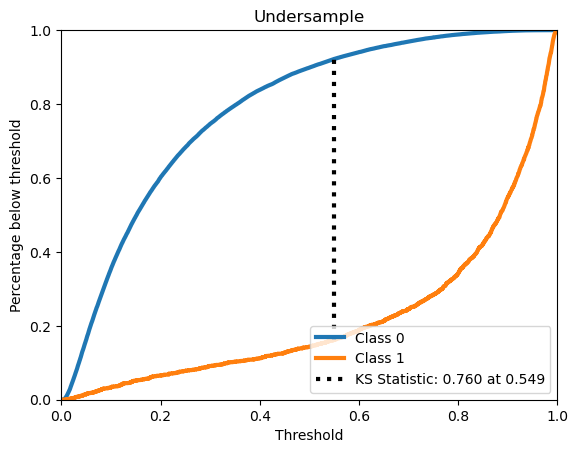

In [7]:
skplt.metrics.plot_ks_statistic(y_test, lr_under_y_pred_proba, title='Undersample')
plt.show()

In [8]:
df = pd.DataFrame()
df['real'] = y_test
df['proba'] = lr_over_y_pred_proba[:,1]

class0 = df[df['real'] == 0]
class1 = df[df['real'] == 1]
ks = ks_2samp(class0['proba'], class1['proba'])
print(f"{ks.statistic:.4f} p-value: {ks.pvalue:.3e}")

0.7615 p-value: 0.000e+00


/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


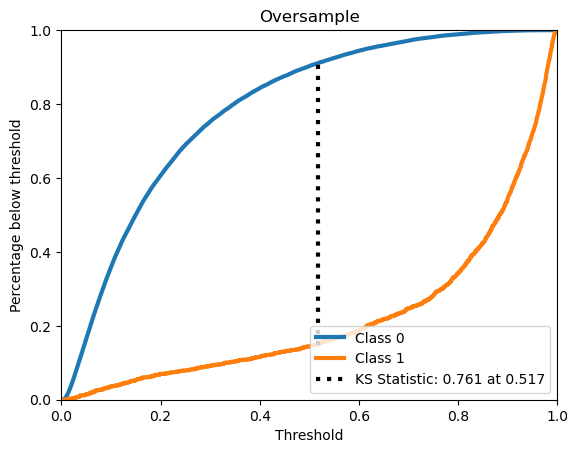

In [9]:
skplt.metrics.plot_ks_statistic(y_test, lr_over_y_pred_proba, title='Oversample')
plt.show()

#### Cut-off

In [10]:
lr_under_cut_off = 0.549
lr_over_cut_off = 0.517
lr_over_y_pred_proba_class = np.where(lr_over_y_pred_proba[:, 1] > lr_under_cut_off, 1, 0)
lr_under_y_pred_proba_class = np.where(lr_under_y_pred_proba[:, 1] > lr_over_cut_off, 1, 0)

### Precision-Recall Curve

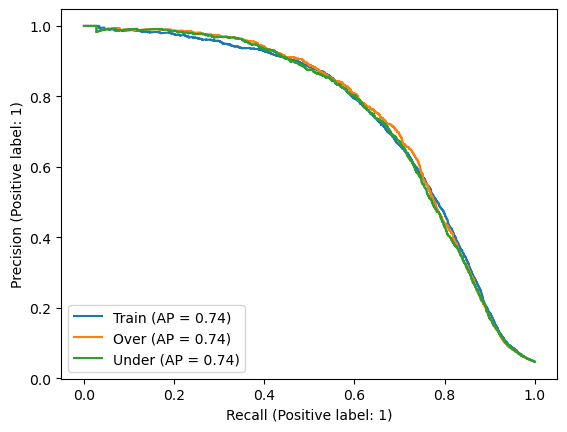

In [11]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(y_train, under_train_pred_proba[:, 1], ax=ax, name="Train")
PrecisionRecallDisplay.from_predictions(y_test, lr_over_y_pred_proba[:, 1], ax=ax, name="Over")
PrecisionRecallDisplay.from_predictions(y_test, lr_under_y_pred_proba[:, 1], ax=ax, name="Under")
plt.show()

<Axes: title={'center': 'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

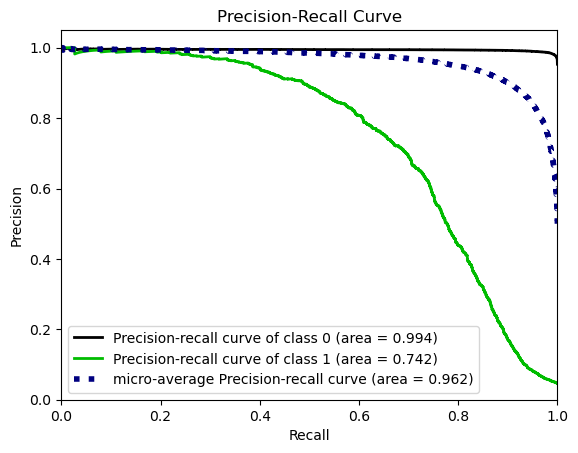

In [12]:
skplt.metrics.plot_precision_recall(y_test, lr_over_y_pred_proba)

### Confussion matrix

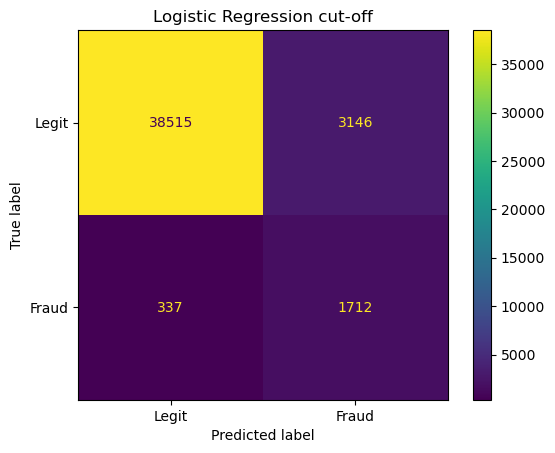

In [13]:
lr_cm = confusion_matrix(y_test, lr_over_y_pred_proba_class)
lr_cm_display = ConfusionMatrixDisplay(confusion_matrix = lr_cm, display_labels = ['Legit', 'Fraud'])
lr_cm_display.plot()
plt.title('Logistic Regression cut-off')
plt.show()

### Cumulative Gain

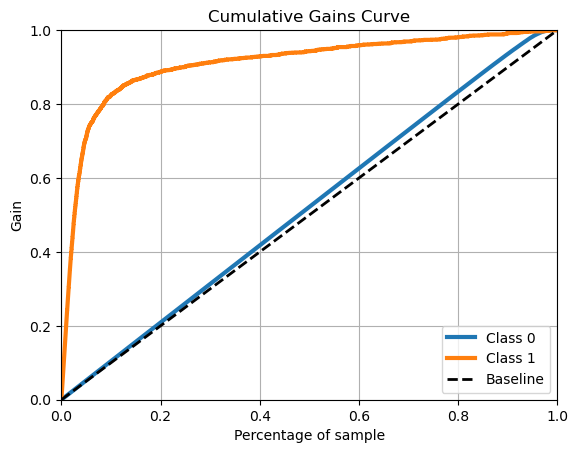

In [14]:
skplt.metrics.plot_cumulative_gain(y_test, lr_over_y_pred_proba)
plt.show()

### ROC

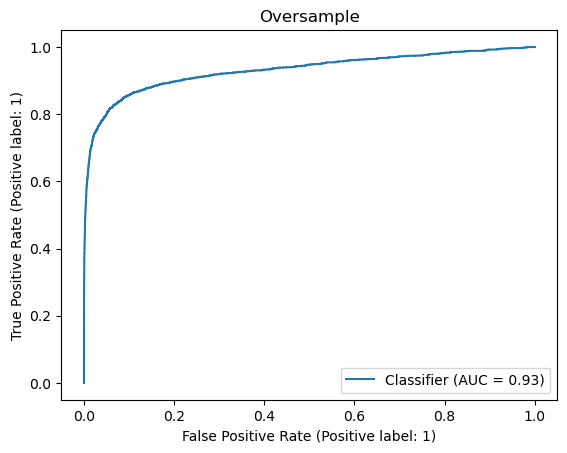

In [15]:
RocCurveDisplay.from_predictions(
    y_test, lr_over_y_pred_proba[:, 1])
plt.title('Oversample')
plt.show()

### Stats

In [16]:
print(f'Accuracy Train: {accuracy_score(y_train, over_train_pred)} Test: {accuracy_score(y_test, lr_over_y_pred_proba_class)}')

Accuracy Train: 0.9018119778797505 Test: 0.9203157172271791


In [17]:
print(classification_report(y_test, lr_over_y_pred_proba_class))

              precision    recall  f1-score   support

           0       0.99      0.92      0.96     41661
           1       0.35      0.84      0.50      2049

    accuracy                           0.92     43710
   macro avg       0.67      0.88      0.73     43710
weighted avg       0.96      0.92      0.94     43710



In [18]:
print(f'The missclasification rate is: {missclassification_rate(y_test, lr_over_y_pred)}')

The missclasification rate is: 0.09938229238160604
